# Chrometric analysis of the dataset 3

---

## 0. Environmental setup

In [28]:
import sys

sys.path.append("../..")

import pandas as pd
import numpy as np
from collections import Counter
import os
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import fdrcorrection
import math
from tqdm.notebook import tqdm
from netneurotools.stats import permtest_pearsonr

from src.utils.data_processing import clean_data, remove_correlated_features

from src.utils.data_processing import clean_data, remove_correlated_features
from src.utils.data_viz import plot_feature_space
from src.utils.discrimination import find_markers

plt.rcParams["figure.dpi"] = 300

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
def run_correlation_screen(data, label_col, b=100000, random_state=1234):
    np.random.seed(random_state)
    results = {
        "feature": [],
        "pearsonr": [],
        "pearsonp": [],
        "pearsonp_adj": [],
        "spearmanr": [],
        "spearmanp": [],
        "spearmanp_adj": [],
    }
    columns = set(data.columns) - {label_col}
    y = np.array(data.loc[:, label_col])
    for col in tqdm(columns):
        x = np.array(data.loc[:, col])
        pr, _ = pearsonr(x, y)
        sr, sp = spearmanr(x, y)

        if not math.isnan(pr):
            _, pp = permtest_pearsonr(x, y, n_perm=b, seed=random_state)

            results["feature"].append(col)
            results["pearsonr"].append(pr)
            results["pearsonp"].append(pp)
            results["spearmanr"].append(sr)
            results["spearmanp"].append(sp)
    results["pearsonp_adj"] = fdrcorrection(results["pearsonp"])[1]
    results["spearmanp_adj"] = fdrcorrection(results["spearmanp"])[1]
    return pd.DataFrame(results)

<IPython.core.display.Javascript object>

---

## 1. Read in data

In [3]:
root_dir = "../../data/dataset3/images/consolidated_features"
nuc_features = pd.read_csv(os.path.join(root_dir, "nuc_features.csv"), index_col=0)
spatial_coords = pd.read_csv(
    os.path.join(root_dir, "spatial_coordiates.csv"), index_col=0
)
nuc_features.head()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,image,nuc_id
0,1,38.0,49.0,0.775510,15.622626,26.617404,20.237664,20.029786,15.622626,17.421532,...,-7.421868e+08,0.170206,0.001789,0.000633,1.456844e-05,1.236669e-09,4.840061e-07,6.535727e-10,Composite DLBCL - 001,Composite DLBCL - 001_1
1,2,54.0,89.0,0.606742,24.580086,48.886338,33.647451,34.246165,24.580086,28.986862,...,-3.173075e+10,0.181028,0.006417,0.000261,2.714211e-05,2.273989e-09,2.173962e-06,-2.011614e-10,Composite DLBCL - 001,Composite DLBCL - 001_2
2,3,71.0,107.0,0.663551,30.955170,56.443155,45.225479,44.011482,30.955170,38.734751,...,-8.011972e+11,0.173351,0.003131,0.000187,8.187018e-06,-2.596249e-10,-3.908685e-07,-1.871194e-10,Composite DLBCL - 001,Composite DLBCL - 001_3
3,4,63.0,70.0,0.900000,28.168770,36.280310,32.117238,32.232702,28.168770,31.126964,...,-1.342501e+10,0.160994,0.000149,0.000132,3.907814e-07,-4.926623e-13,-6.196298e-10,-2.768201e-12,Composite DLBCL - 001,Composite DLBCL - 001_4
4,5,46.0,56.0,0.821429,20.904613,28.679452,24.657342,24.606879,20.904613,23.443352,...,-1.839987e+09,0.161983,0.000532,0.000035,6.850657e-07,9.750960e-14,-3.106200e-09,3.372227e-12,Composite DLBCL - 001,Composite DLBCL - 001_5


<IPython.core.display.Javascript object>

In [4]:
roi_metadata = pd.read_csv("../../data/dataset3/DLBCL_ROIs_DZ_ranking.csv", index_col=0)
roi_metadata.head()

,ROILabel,DZ_total_expr
SlideName,,
Composite DLBCL - 006,6,8230.12
Composite DLBCL - 004,4,8077.16
DLBCL Repeat - 011,11,7957.10
Composite DLBCL - 003,3,7936.55
Composite DLBCL - 002,2,7722.37


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we start our analysis, we will briefly save some meta information which are later removed from the dataframe for the purposes of analysis.

In [5]:
images = np.array(nuc_features.image)
nuc_ids = np.array(nuc_features.nuc_id)
labels = np.array(nuc_features.label)
nuc_features.index = nuc_ids

<IPython.core.display.Javascript object>

We now remove a number of meta-features and remove samples with missing entries in the feature matrix as well as constant features.

In [6]:
meta_columns = [
    "label",
    "weighted_centroid-0",
    "weighted_centroid-1",
    "centroid-0",
    "centroid-1",
    "bbox-0",
    "bbox-1",
    "bbox-2",
    "bbox-3",
    "nuc_id" "image",
    "orientation",
]
# drop_columns = set(meta_columns).union(
#     set(list(nuc_features.filter(regex="-").columns))
# )

<IPython.core.display.Javascript object>

In [7]:
cleaned_nuc_feat = clean_data(
    nuc_features, drop_columns=meta_columns, index_col="nuc_id"
)

Removed 19 constant or features with missing values. Remaining: 183.
Removed additional 6 features. Remaining: 177.
Removed 0 samples with missing values. Remaining: 24661.


<IPython.core.display.Javascript object>

We note that 25 features are removed but no sample was filtered out. The total size of the dataset is 24,661 nuclei. Importantly we have not filtered out nuclei at the boundary of the ROI for now.

We now remove highly correlated features by setting a threshold on the Pearson correlation of 0.8.

In [8]:
filtered_nuc_feat = remove_correlated_features(cleaned_nuc_feat, 0.8)

Removed 112/177 features with a Pearson correlation above 0.8. Remaining: 65


<IPython.core.display.Javascript object>

This step removes 112/177 features which means that the processed data matrix consists of 24,661 nuclei described by 65 chrometric features.

## 3. Data visualization

To get a better understanding of the data set and potential batch effects, we will now plot a UMAP representation of the data set.

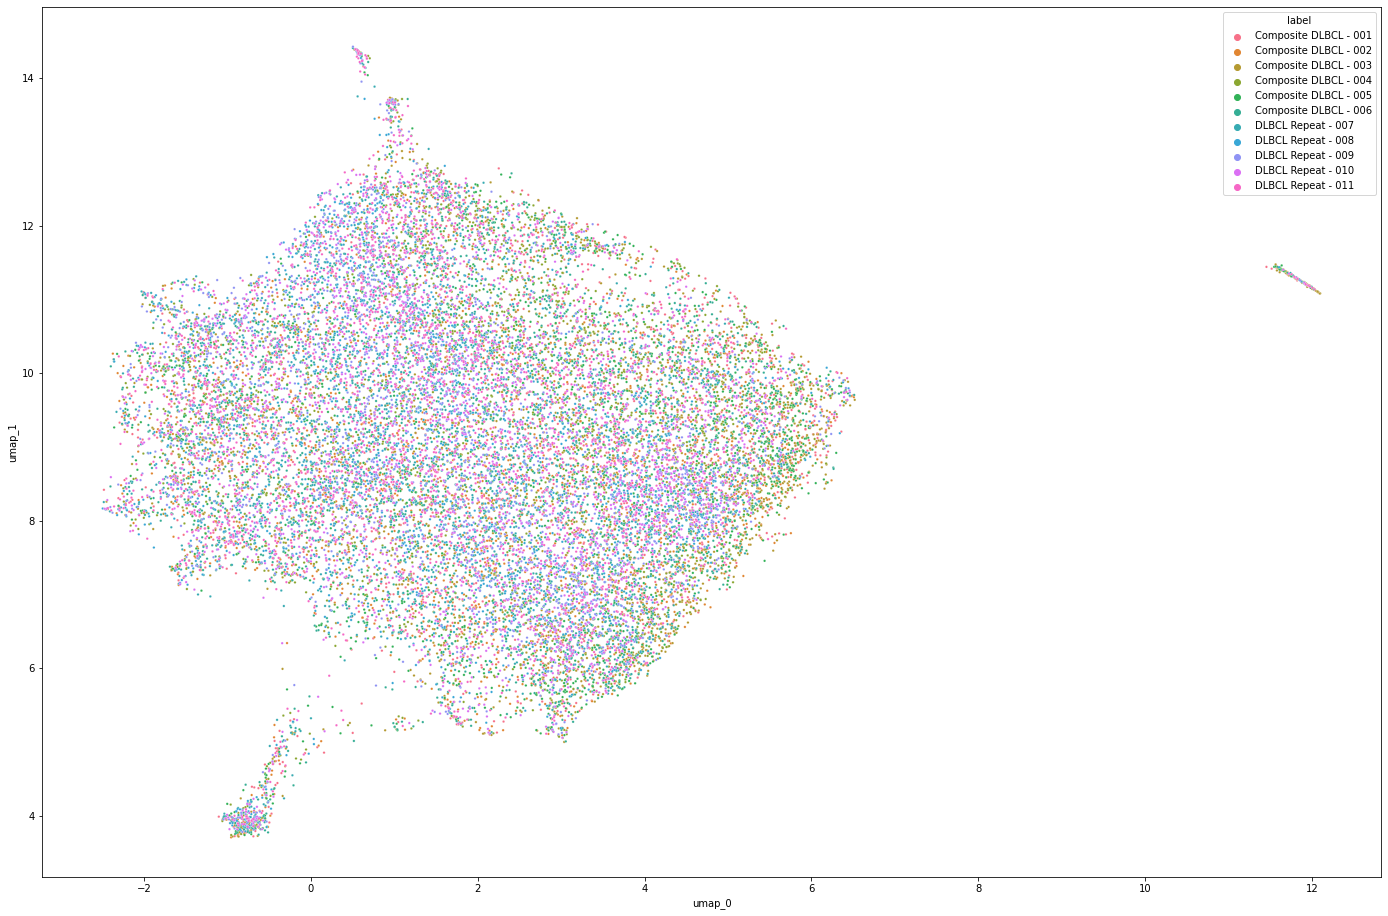

<IPython.core.display.Javascript object>

In [9]:
umap_embs = plot_feature_space(
    filtered_nuc_feat, labels=images, mode="umap", figsize=[24, 16], alpha=1, s=6
)

The above plot shows the representation of the data set each nuclei represented by a single point colored by the individual ROI images. We observe 4 distinct clusters that however seem to be populated by nuclei from various ROI. Thus, we do not see any strong batch effects.
Nonetheless, we will cluster the UMAP space to identify what those clusters are. To this end, we use a HDBScan algorithm.

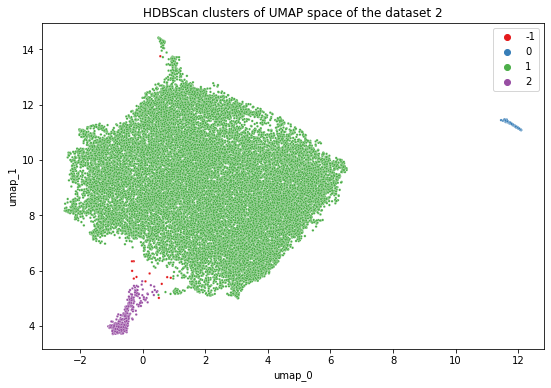

<IPython.core.display.Javascript object>

In [10]:
umap_num_embs = np.array(umap_embs.iloc[:, :-1])
cluster_labels = HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(
    umap_num_embs
)
clustered = cluster_labels >= 0
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=umap_embs, x="umap_0", y="umap_1", hue=cluster_labels, palette="Set1", s=6
)
ax.set_title("HDBScan clusters of UMAP space of the dataset 2")
plt.show()

We see that the cluster identified nicely matches what we would visually expect to be the four different clusters. We thus, will now in particular aim to characterize the clusters 0, 1 and 3 to understand what those represent.

In [11]:
cluster_markers = find_markers(filtered_nuc_feat, cluster_labels)

Run marker screen: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.96it/s]


<IPython.core.display.Javascript object>

#### Cluster 0

In [12]:
cluster_markers.loc[
    (cluster_markers.label == 0) & (cluster_markers.adjusted_pval < 1e-5)
].sort_values("abs_delta_fc", ascending=False).head(10)

,label,marker,fc,abs_delta_fc,pval,adjusted_pval
14,0,skewness,9.916805,8.916805,7.161325e-84,1.241296e-82
13,0,kurtosis,-1.027670,2.027670,1.583213e-07,5.277378e-07
19,0,contrast_1,2.527402,1.527402,1.182081e-58,1.336265e-57
18,0,hc_area_ec_area,0.001664,0.998336,0.000000e+00,0.000000e+00
47,0,weighted_moments_hu-3,0.012006,0.987994,2.047736e-39,1.478921e-38
12,0,int_d25,1.973960,0.973960,1.395299e-140,3.023148e-139
46,0,weighted_moments_hu-2,0.031717,0.968283,2.076208e-161,5.997935e-160
45,0,weighted_moments_hu-1,0.114539,0.885461,6.602719e-267,3.433414e-265
28,0,weighted_moments_normalized-1-3,0.128105,0.871895,2.870666e-08,9.951641e-08
34,0,weighted_moments_normalized-3-1,0.147297,0.852703,4.874786e-10,2.044265e-09


<IPython.core.display.Javascript object>

The samples in the cluster 0 seem to be dominated by nuclei with a significantly larger skewness in the distribution and substantially higher contrast values suggesting less smooth texture of the chromatin.
Importantly, we validate that the cluster contains nuclei from all ROI images although most samples come from ROI 1 and ROI 3 where those samples correspond to roughly 2% respectively 3% of all nuclei in the data set.

In [13]:
image_counts = dict(Counter(images))
cluster0_counts = dict(Counter(images[cluster_labels == 0]))
for k, v in cluster0_counts.items():
    print(k, np.round(v / image_counts[k], 4))

Composite DLBCL - 001 0.0194
Composite DLBCL - 002 0.0046
Composite DLBCL - 003 0.0302
Composite DLBCL - 004 0.0039
Composite DLBCL - 005 0.0119
Composite DLBCL - 006 0.0018
DLBCL Repeat - 007 0.0032
DLBCL Repeat - 008 0.0013
DLBCL Repeat - 009 0.0013
DLBCL Repeat - 010 0.0017
DLBCL Repeat - 011 0.0043


<IPython.core.display.Javascript object>

---

#### Cluster 1

In [14]:
cluster_markers.loc[
    (cluster_markers.label == 1) & (cluster_markers.adjusted_pval < 1e-5)
].sort_values("abs_delta_fc", ascending=False).head(10)

,label,marker,fc,abs_delta_fc,pval,adjusted_pval
46,1,weighted_moments_hu-2,4.360608,3.360608,1.357556e-81,2.076262e-80
47,1,weighted_moments_hu-3,2.930599,1.930599,3.570477e-13,1.751555e-12
63,1,moments_hu-2,2.168900,1.168900,2.199082e-63,3.009270e-62
8,1,num_prominant_pos_curv,2.033891,1.033891,1.577813e-12,7.596876e-12
23,1,correlation_20,0.003725,0.996275,1.457962e-43,1.148697e-42
39,1,weighted_moments_central-1-1,0.134166,0.865834,2.319627e-09,9.278509e-09
26,1,weighted_moments_normalized-1-1,0.247842,0.752158,7.704063e-12,3.514134e-11
34,1,weighted_moments_normalized-3-1,0.253407,0.746593,3.564790e-10,1.519419e-09
28,1,weighted_moments_normalized-1-3,0.265564,0.734436,3.088747e-09,1.216779e-08
14,1,skewness,0.292638,0.707362,4.481522e-31,3.066304e-30


<IPython.core.display.Javascript object>

In [15]:
cluster1_counts = dict(Counter(images[cluster_labels == 1]))
for k, v in cluster1_counts.items():
    print(k, np.round(v / image_counts[k], 4))

Composite DLBCL - 001 0.9516
Composite DLBCL - 002 0.9721
Composite DLBCL - 003 0.9488
Composite DLBCL - 004 0.9803
Composite DLBCL - 005 0.9632
Composite DLBCL - 006 0.9741
DLBCL Repeat - 007 0.9727
DLBCL Repeat - 008 0.9789
DLBCL Repeat - 009 0.983
DLBCL Repeat - 010 0.9801
DLBCL Repeat - 011 0.9814


<IPython.core.display.Javascript object>

The second cluster does dominantely consist of nuclei of first set of ROIs. The cluster is enriched for nuclei with more regular texture and enlarged nuclei.

---

In summary the difference in the class frequencies of the indvidual clusters will inform our downstream analysis when comparing the individual ROIs. In particular, we will run the analysis in two ways: one time using all nuclei and another time only using the nuclei from the largest UMAP cluster thus excluding those special cases.

---

## 3. Comparison of the ROIs

When comparing the individual ROIs we are in particular interested in understanding which features correlate with the measured DZ expression given in the metadata. To identify those, we will first compute the median values for each of the ROIs and compute the Pearson and Spearman correlation coefficient for each feature with the respective expression value.

In [9]:
median_nuc_feat = filtered_nuc_feat.copy()
median_nuc_feat.loc[:, "image"] = images
median_nuc_feat = median_nuc_feat.groupby("image").median()
median_nuc_feat.head()

,min_calliper,smallest_largest_calliper,std_radius,concavity,avg_curvature,std_curvature,max_posi_curv,med_posi_curv,num_prominant_pos_curv,num_prominant_neg_curv,...,moments_normalized-2-3,moments_normalized-3-0,moments_normalized-3-2,moments_central-0-1,moments_central-1-0,moments_central-2-3,moments_central-3-0,moments_central-3-2,moments_hu-2,moments_hu-6
image,,,,,,,,,,,,,,,,,,,,,
Composite DLBCL - 001,40.0,0.672003,3.712246,0.030529,0.029284,0.121171,0.315152,0.17826,0.0,1.0,...,-0.000015,-0.000023,0.000017,1.776357e-14,4.929390e-14,-201571.800652,-401.984910,221476.938895,0.000211,3.280989e-15
Composite DLBCL - 002,40.0,0.666667,3.909091,0.029430,0.028994,0.120611,0.315152,0.17826,0.0,1.0,...,-0.000017,-0.000083,0.000027,-7.460699e-14,2.842171e-14,-483980.478996,-2538.336838,535115.545823,0.000198,1.997031e-14
Composite DLBCL - 003,43.0,0.684211,3.846813,0.028600,0.027786,0.121169,0.285714,0.17826,0.0,1.0,...,-0.000015,-0.000055,0.000018,-3.730349e-14,-7.549517e-14,-159808.854589,-1056.921380,220211.348143,0.000196,-3.106000e-15
Composite DLBCL - 004,36.0,0.682733,3.395219,0.032034,0.031988,0.121791,0.309017,0.17826,0.0,1.0,...,-0.000019,0.000026,-0.000012,6.661338e-14,-3.463896e-14,-218184.506455,272.901664,-56248.491585,0.000214,-7.067050e-15
Composite DLBCL - 005,42.0,0.681159,3.806850,0.029426,0.028071,0.120693,0.285714,0.17826,0.0,1.0,...,-0.000004,-0.000182,0.000008,-1.421085e-14,1.136868e-13,-42535.898677,-5184.104723,224357.445261,0.000198,7.791257e-17


<IPython.core.display.Javascript object>

We decided to use the median to be more robust to outliers in the data set.

In [10]:
median_nuc_feat.loc[:, "dz_expr"] = np.array(
    roi_metadata.loc[median_nuc_feat.index, "DZ_total_expr"]
)

<IPython.core.display.Javascript object>

In [13]:
cor_screen_results = run_correlation_screen(median_nuc_feat, "dz_expr", b=int(1e5))


  0%|          | 0/65 [00:00<?, ?it/s]

/usr/share/miniconda3/envs/gc/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/share/miniconda3/envs/gc/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/share/miniconda3/envs/gc/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<IPython.core.display.Javascript object>

In [30]:
cor_screen_results.sort_values("pearsonp_adj", ascending=True).head(5)

,feature,pearsonr,pearsonp,pearsonp_adj,spearmanr,spearmanp,spearmanp_adj
33,hc_area_ec_area,0.884320,0.000200,0.012399,0.927273,0.000040,0.002464
14,nhigh_nlow,-0.752176,0.009799,0.303770,-0.706152,0.015154,0.287758
50,skewness,0.691582,0.021498,0.444289,0.500000,0.117307,0.972196
60,correlation_1,-0.634948,0.040496,0.627687,-0.436364,0.179665,0.972196
27,moments_hu-6,-0.545575,0.057294,0.710449,-0.700000,0.016471,0.287758


<IPython.core.display.Javascript object>

We see that the only feature that significantly (FDR < 0.05) correlated with the measured DZ expression is the HC/EC ratio. Interestingly, that feature was not among the most discriminative features for distinguishing light zone B cells from dark zone B cells. This can be explained by the fact that the applied quantile normalization to deal with the different brightness levels of the individual nuclei yields similar intensity distributions within the ROIs thus comparing the median I80_I20 (that is the ratio of the 80%tile and 20%tile) will be very similar for each ROI thus not correlated with the different expression levels.

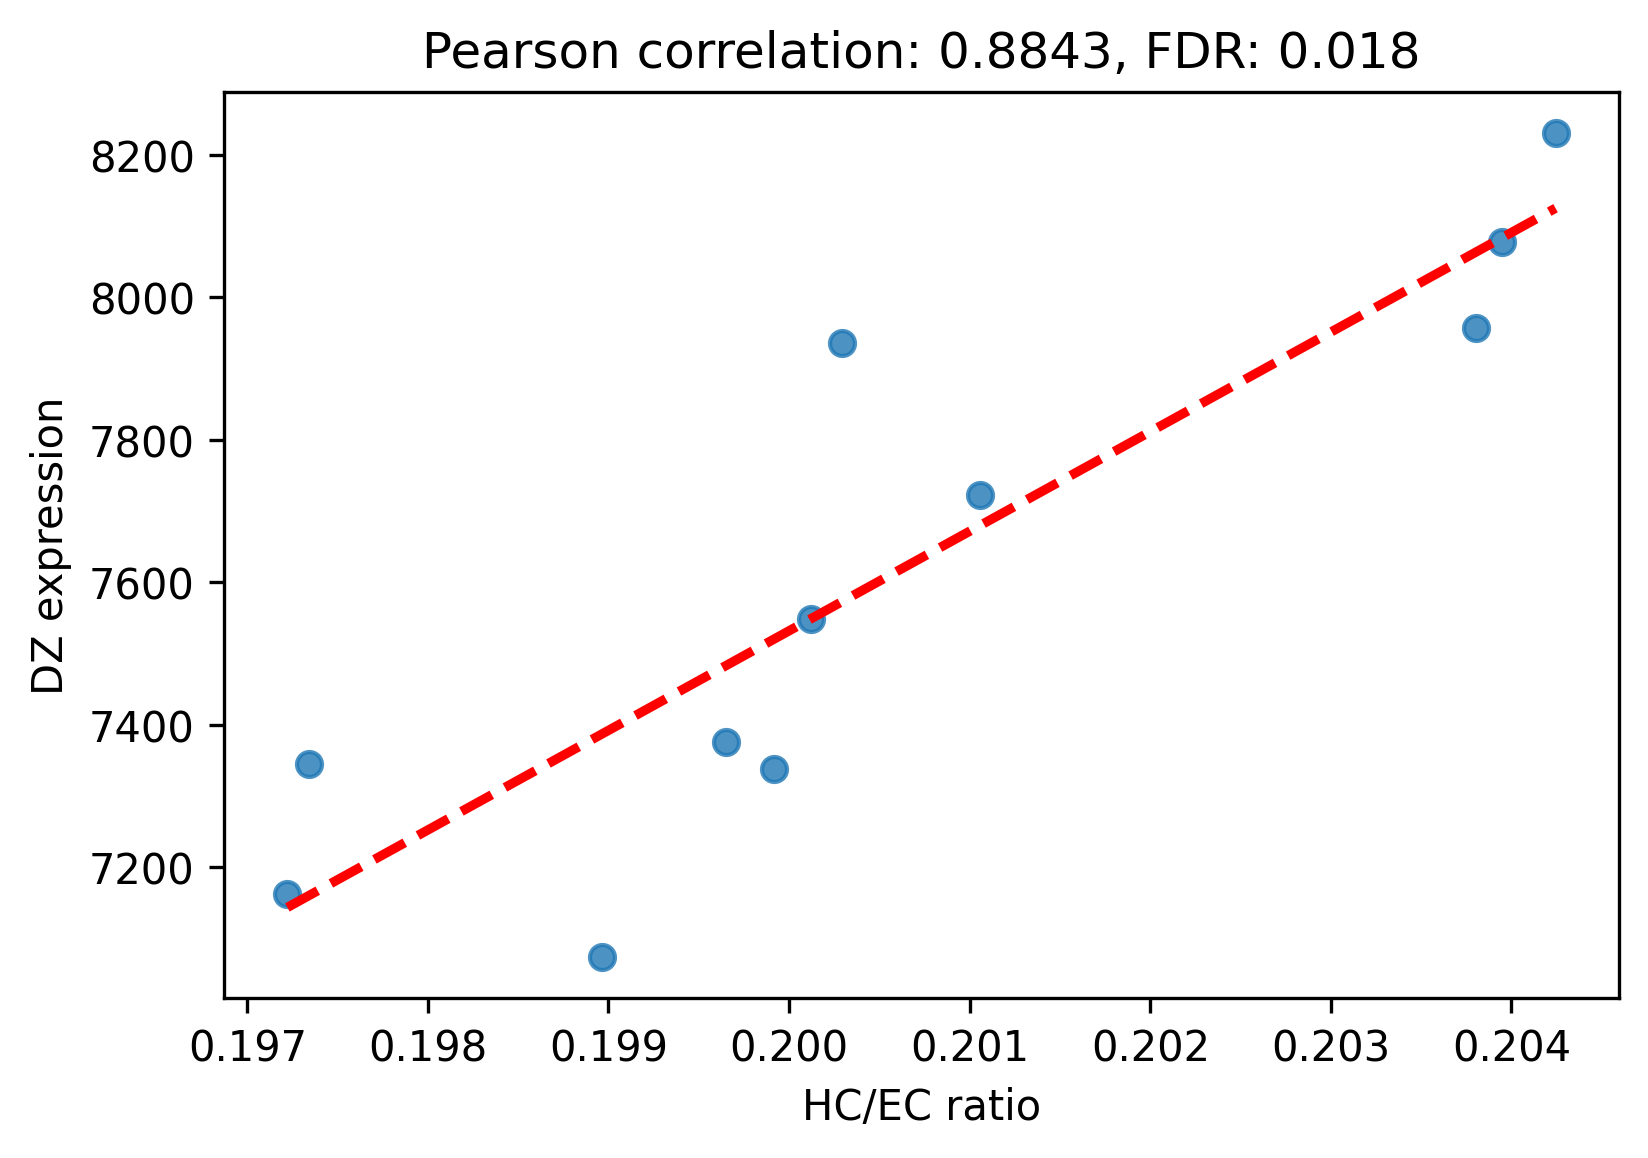

<IPython.core.display.Javascript object>

In [36]:
pr_pp_adj = np.array(
    cor_screen_results.loc[
        cor_screen_results.feature == "hc_area_ec_area", ["pearsonr", "pearsonp_adj"]
    ]
).flatten()
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.regplot(
    data=median_nuc_feat,
    x="hc_area_ec_area",
    y="dz_expr",
    ax=ax,
    x_ci=None,
    ci=None,
    line_kws={"color": "r", "linestyle": "--"},
)
ax.set_title(
    "Pearson correlation: {}, FDR: {}".format(
        np.round(pr_pp_adj[0], 4), np.round(pr_pp_adj[1], 4)
    )
)
ax.set_ylabel("DZ expression")
ax.set_xlabel("HC/EC ratio")
plt.show()

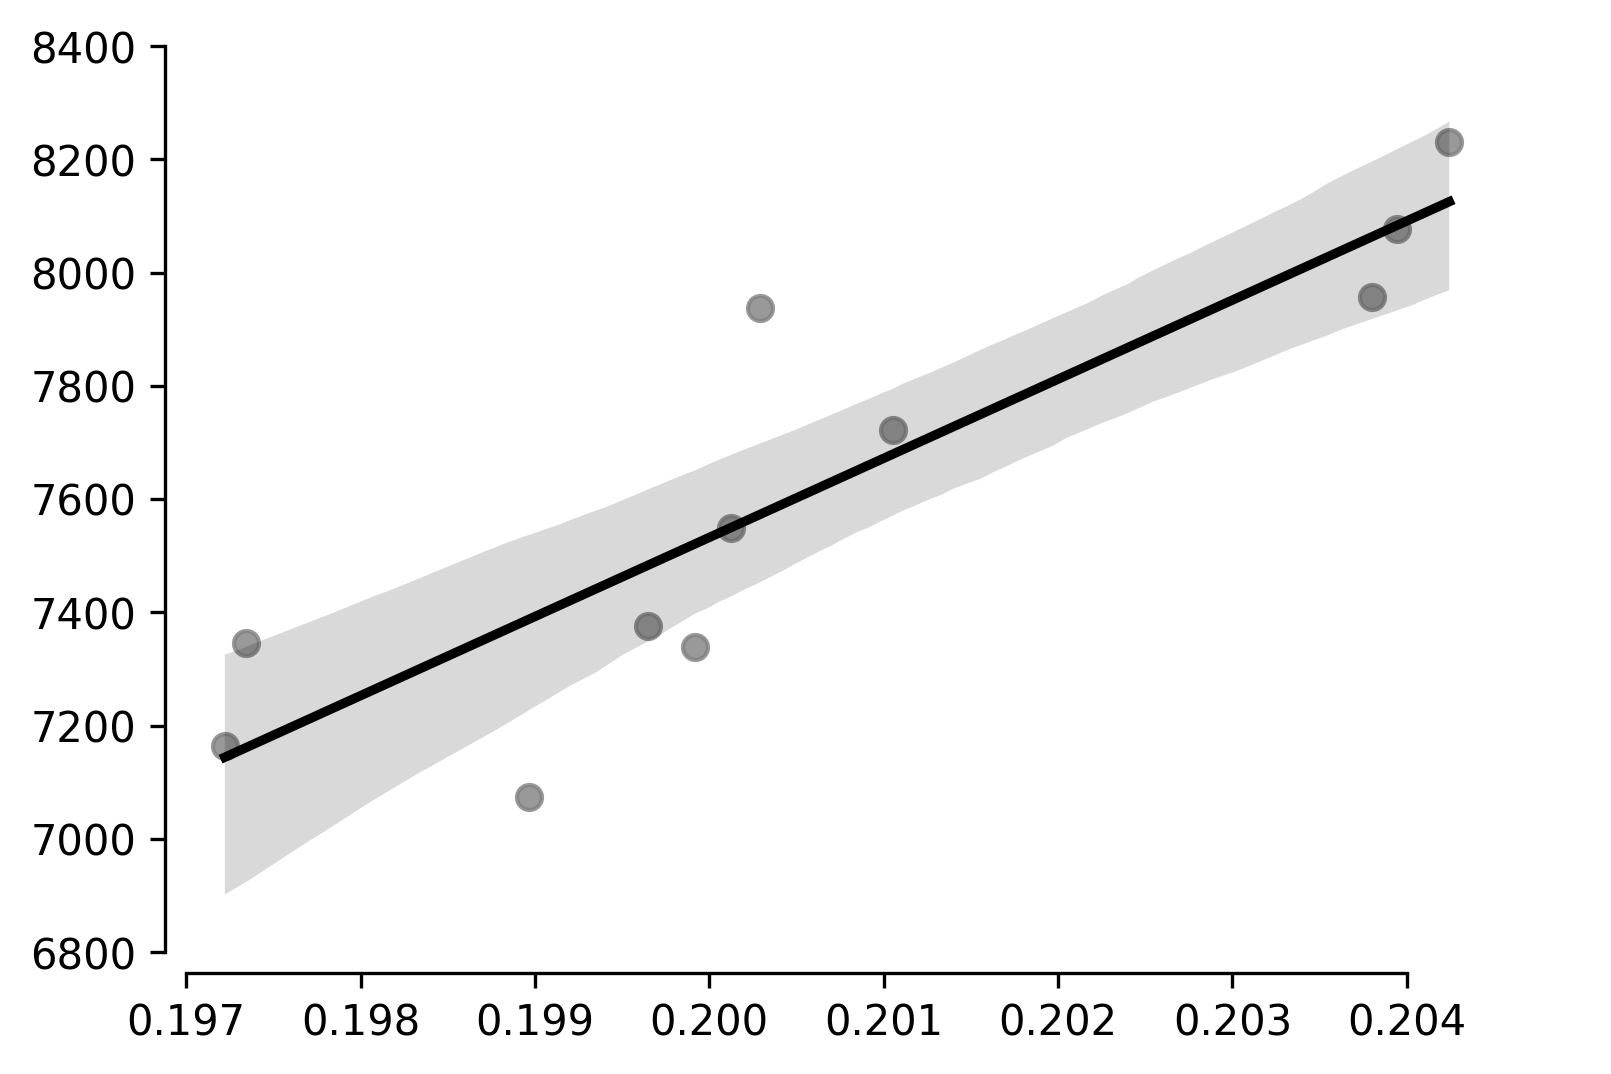

<IPython.core.display.Javascript object>

In [35]:
pr_pp_adj = np.array(
    cor_screen_results.loc[
        cor_screen_results.feature == "hc_area_ec_area", ["pearsonr", "pearsonp_adj"]
    ]
).flatten()
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.regplot(
    data=median_nuc_feat,
    x="hc_area_ec_area",
    y="dz_expr",
    ci=95,
    scatter_kws={"color": "gray"},
    line_kws={"color": "k"},
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_ylim([6800, 8400])
ax.set_xlim([0.197, 0.205])
sns.despine(offset=5, trim=True)
plt.show()

We have also checked if a linear combination of the important dark zone B cell features allows for a fit of the linear regression significantly better than a simple intercept model but that is not the case. In conclusion, the results indicate that however the chromatin condensation can be linked to the dark-zone like phenotype. The quality of the given image data set, the extremely small sample size and the heterogeneous cell distribution observed in the samples do not allow for any stronger statement at the time being.